## Ejemplo de LSTM para predecir valores de acciones (stock prediction)
Estructura del LSTM (repaso):

* La **forget gate**:
$$  f_t = \sigma( W_f x_t + U_f h_{t-1} + b_f). $$

* La **input gate**:
\begin{eqnarray}
  i_t &=& \sigma( W_i x_t + U_i h_{t-1} + b_i)   \\
  \tilde{c}_t &=& \tanh( W_g x_t + U_g h_{t-1} + b_g).
\end{eqnarray}

* La **cell state**:
$$   c_t = c_{t-1} \circ f_t + i_t \circ \tilde{c}.  $$

* La **output gate**:
\begin{eqnarray}
  o_t &=& \sigma(W_0 x_t +  U_o h_{t-1} + b_o)  \\
  h_t &=& \tanh(c_t) \circ o_t.  
\end{eqnarray}


## Que vamos a ver hoy

* Un ejemplo a mano. (matrices de $1 \times 1$). De acciones (stocks). Mal resultado, lo importante es entender la tecnica.


* Un ejemplo en `Python`.

* El gradiente (por tercera vez). Para analizar el vanishing/exploding gradient.

**Ejemplo**:
Tenemos una curva de "stocks".




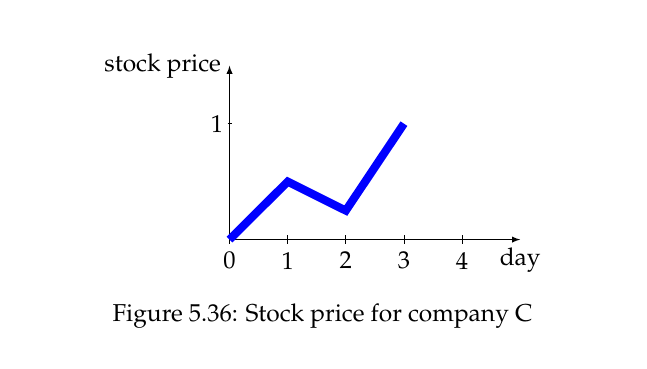

El proposito es adivinar el precio de la accion en el dia 4.
Se tienen los siguientes datos.

$$W_f=-1.2 \quad, \quad U_f=2.3 \quad , \quad b_f=0.62 $$
$$W_i=0.65 \quad, \quad U_i = 0.4 \quad , \quad b_i=-1.4 $$
$$W_g=-0.9 \quad, \quad U_g = -1.41 \quad , \quad b_g=0.22 $$
$$W_o=0.39 \quad, \quad U_o = 4.38 \quad , \quad b_o=0.79 $$

Comenzamos en ceros.

### Dia 1:
* **Forget gate**
$$f_1 = \sigma( -1.2 \cdot 0  + 2.3 \cdot 0 + 0.62 ) \approx 0.65 $$

* **Input cell**:
$$i_1 = \sigma(0.65 \cdot 0 + 0.4 \cdot 0 -1.4) \approx 0.2 $$

* **State cell**
$$g_1 = \tanh(-0.9 \cdot 0 + (-1.41) \cdot 0 + 0.22) \approx 0.22 $$

* **output cell**
$$o_t = \sigma(0.39 \cdot 0 + 4.28 \cdot 0 + 0.79) \approx 0.69 $$

* **Cell state**
$$c_1 = 0 \cdot 0.65 + 0.2 \cdot 0.22 \approx 0.04 $$

* **short term memory h_1**:
$$ h_1 = \tanh(0.04) \cdot 0.69 \approx 0.03 $$

## Dia 2:
Se encontraron los siguientes valores
\begin{eqnarray}
f_2 &=& 0.52 \\
i_2 &=& 0.26 \\
g_2 &=& -0.27 \\
o_2 &=& 0.75 \\
c_2 &=& -0.05 \\
h_2 &=& -0.03 \\
\end{eqnarray}

## Dia 3:
Se encontraron los siguientes valores
\begin{eqnarray}
f_3&=& 0.56 \\
i_3 &=& 0.22 \\
g_3 &=& 0.04 \\
o_3 &=& 0.68 \\
c_3 &=& -0.02 \\
h_3 &=& -0.01 \\
\end{eqnarray}


## Dia 4:
Se encontraron los siguientes valores
\begin{eqnarray}
f_4 &=& 0.35 \\
i_4 &=& 0.32 \\
g_4 &=& -0.58 \\
o_4 &=& 0.76 \\
c_4 &=& -0.19 \\
h_4 &=& -0.14 \\
\end{eqnarray}

La memoria corta nos da un estimado de $-0.14$ y la larga de $-0.19$. Esto no tiene sentido por que las acciones tienen valor positivo o 0.


In [8]:
# un ejemplo practico (object oriented)
# forward propagation only
import numpy as np

class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        # weights for the input gate
        self.W_i = np.random.randn(hidden_size, input_size)
        self.U_i = np.random.randn(hidden_size, hidden_size)
        self.b_i = np.random.randn(hidden_size, 1)

        # weights for the forget gate
        self.W_f = np.random.randn(hidden_size, input_size)
        self.U_f = np.random.randn(hidden_size, hidden_size)
        self.b_f = np.random.randn(hidden_size, 1)

        # Weights for the cell state
        self.W_c = np.random.randn(hidden_size, input_size)
        self.U_c = np.random.randn(hidden_size, hidden_size)
        self.b_c = np.random.randn(hidden_size, 1)

        # Weights for the output gate
        self.W_o = np.random.randn(hidden_size, input_size)
        self.U_o = np.random.randn(hidden_size, hidden_size)
        self.b_o = np.random.randn(hidden_size, 1)


    def S(self, x):
        return 1/(1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def forward(self, x_t, h_prev, C_prev):
        # input gate
        i_t = self.S(np.dot(self.W_i, x_t) + np.dot(self.U_i, h_prev) + self.b_i)

        # Forget gate
        f_t = self.S(np.dot(self.W_f, x_t) + np.dot(self.U_f, h_prev) + self.b_f)

        # Cell state candidate
        C_t_virgulilla = self.tanh(np.dot(self.W_c, x_t) + np.dot(self.U_c, h_prev) + self.b_c)

        # New cell state
        C_t = f_t * C_prev + i_t * C_t_virgulilla

        # output date
        o_t = self.S(np.dot(self.W_o, x_t) + np.dot(self.U_o, h_prev) + self.b_o)

        # New hidden state
        h_t = o_t * self.tanh(C_t)

        return h_t, C_t



In [11]:
# prueba del algoritmo
# definimos parametros
input_size = 3
hidden_size = 2

# creamos la celda
lstm_cell = LSTMCell(input_size, hidden_size)

# creamos datos dummies
x_t = np.random.randn(input_size, 1) # input
h_prev = np.zeros((hidden_size, 1)) # hidden state
C_prev = np.zeros((hidden_size, 1)) # cell state

# forward pass through LSTM
h_t, C_t = lstm_cell.forward(x_t, h_prev, C_prev)

print("New hidden state h_t")
print(h_t)
print("New cell state C_t")
print(C_t)

New hidden state h_t
[[ 0.0052908 ]
 [-0.24974437]]
New cell state C_t
[[ 0.00759512]
 [-0.30387893]]


## Revisita al Gradiente.

Para hacer propagacion hacia atras, debemos definir la funcion de costo.

$$J = \sum_{t=1}^T J_t $$

Los pesos $W$ los escribimos como  $W=[W_f, U_f, b_f]$
Nos interesa el gradiente de cada uno de los $J_t$, $t=1,2, \cdots , T$.

$$J_k = J_k(h_k, c_k, W) $$
Para hallar el gradiente con respecto a $W$ usamos la regla de la cadena. Solo nos enfocarmos en el **forget gate**.

\begin{eqnarray}
\frac{\partial J_k}{\partial w} &=&
\frac{\partial J_k}{\partial h_k}
\frac{\partial h_k}{\partial c_k}
\frac{\partial c_k}{\partial c_{k-1}}
\cdots
\frac{\partial c_2}{\partial c_1}
\frac{\partial c_1}{\partial W} \\
&=& \frac{\partial J_k}{\partial h_k}
\frac{\partial h_k}{\partial c_k}
\prod_{t=k}^2 \frac{\partial c_t}{\partial c_{t-1}}
\frac{\partial c_1}{\partial W} \quad , \quad k > 2
\end{eqnarray}

Nos enfocamos en la productoria.

\begin{eqnarray}
\frac{\partial c_t}{\partial c_{t-1}} &=&
\frac{\partial c_{t-1}}{\partial c_{t-1}} \circ f_t +
c_{t-1} \circ \frac{\partial f_t}{\partial c_{t-1}} +
\frac{\partial i_t}{\partial c_{t-1}} \circ \tilde{c}_t +
i_t \circ \frac{\partial \tilde{c}_t}{\partial c_{t-1}}  \\
&=&
I \circ f_t + c_{t-1} \circ \frac{\partial f_t}{\partial c_{t-1}}
 + \frac{\partial i_t}{\partial c_{t-1}} \circ \tilde{c}_t + i_t \circ \frac{\partial \tilde{c}_t}{\partial c_{t-1}} \tag{3}
\end{eqnarray}


Analizamos esta expresion termino por termino.

* El primer termino. La identidad es **super** estable.
Es una matriz diagonal, con $f_t$ en la diagonal. $f_t$ puede
ser menor que uno pues es un sigmoid. Esto prodria ser un problema en el vanishing gradient. Pero hay otras cosas que suman.

* Termino
$$ \frac{\partial f_t}{\partial c_{t-1}} $$
Sabemos que

$$f_t= \sigma( W_f x_t + U_f h_{t-1} + b_f) =\sigma( W_f x_t + U_f \tanh(c_{t-1}) \circ o_{t-1}  + b_f) $$

Llamemos $z=W_f x_t + U_f \tanh(c_{t-1})\circ o_{t-1}  + b_f$
entonces

$$\frac{\partial f_t}{\partial c_{t-1}} = \sigma'(z) U_f \tanh'(c_{t-1})( I \circ o_{t-1})$$

donde la identidad $I$ viene de $\partial c_{t-1}/\partial c_{t-1}$
Analicemos valores:

$$ 0 \le \sigma'(z) \le 0.25 $$
$$ 0 \le \tanh'(z) \le 1 $$
$$ 0 \le o_{t-1} \le 1. $$
No tenemos mucho control subre $U_f$, probablemente se puede normalizar.

* Termino
$$\frac{\partial i_t}{\partial c_{t-1}} $$










$$i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i) = \sigma( W_i x_t + U_i \tanh(c_{t-1}) \circ o_{t-1} + b_i)$$

Llamamos $z=  W_i x_t + U_i \tanh(c_{t-1}) \circ o_{t-1} + b_i$
entonces

$$\frac{\partial i_t}{\partial c_{t-1}} = \sigma'(z) U_i \tanh'(c_{t-1}) I \circ o_{t-1}  $$
Como en el caso anterior todos son pequenhos, exepto posiblmente el $U_i$

Finalmente

* Termino
$$\frac{\partial \tilde{c}_t}{\partial c_{t-1}} $$

$$\tilde{c} = \tanh( W_c x_t + U_c h_{t-1} + b_c) = \tanh ( W_c x_t + U_c \tanh(c_{t-1}) \circ o_{t-1} + b_c  $$

llamando $z=W_c x_t + U_c h_{t-1} + b_c$ encontramos

$$\frac{\partial \tilde{c}_t}{\partial c_{t-1}} = \tanh'(z) U_c \tanh'(c_{t-1}) I \circ o_{t-1} $$

De nuevo tenemos en cuenta que $\tanh'(z) \in [0,1]$
lo mismo que $o_{t-1}$ (por que es un sigmoid).
De nuevo el control debe ser sobre $U_c$.

En conclusion, la suma de los cuatro terminos de la ecuacion (3)
estan "bajo control". No explotan ni se van a cero. Esto es un argumento "waving hands". De todas formas el LSTM ha probado ser muy estbale incluso hasta 1000 pasos, que las RNN no lo pueden hacer.

Para acabar la clase voy a hacer una lista corta de aplicaciones de LSTM:

* Generacion de musica. (caiga en la nota, a  proxima nota.).
* Sentiment Classification.
* Machine Translation
* Prediccion de trayectorias (autonomous driving)
* Image classificaion and captioning
* Voice transcription.